/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Precision: 0.99
Recall: 0.95
F1-Score: 0.97
AUC-ROC Score: 0.99


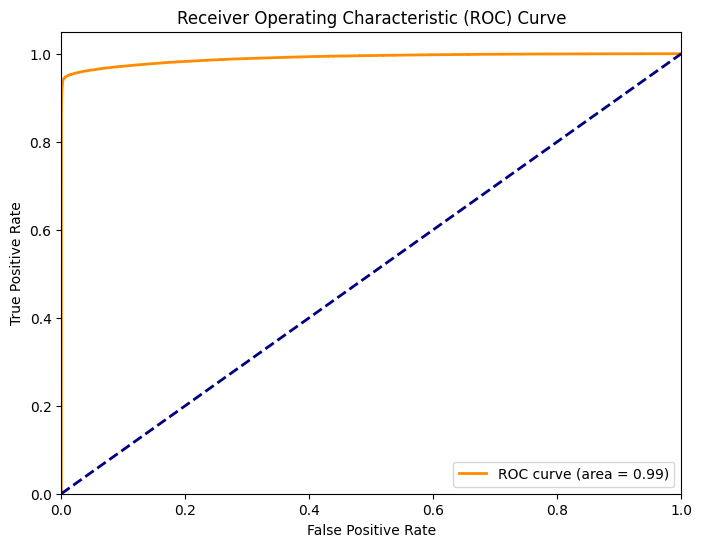

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('/content/loan_level_500k.csv')  # Replace with the correct path to your dataset.

# Get features and target
selected_features = ['CREDIT_SCORE', 'MORTGAGE_INSURANCE_PERCENTAGE', 'ORIGINAL_DEBT_TO_INCOME_RATIO',
                     'ORIGINAL_UPB', 'ORIGINAL_LOAN_TO_VALUE', 'ORIGINAL_INTEREST_RATE']
X = df[selected_features]
y = df['DELINQUENT']

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Apply SMOTE for oversampling the minority class
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_imputed, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3)

# Train the XGBoost model with early stopping
model = XGBClassifier(n_estimators=1000, max_depth=5, scale_pos_weight=1, reg_lambda=1, reg_alpha=0.01, learning_rate=0.1)

# Use early stopping to prevent overfitting
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="logloss", eval_set=eval_set, early_stopping_rounds=10, verbose=False)

# Predict the target values
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate the evaluation metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_prob)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC Score: {auc_roc:.2f}")

# Plot the AUC-ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
